# Visualizations for VAST 2017 Mini Challenge 2

#### References:
* [Wikipedia - air pollution dispersion](https://en.wikipedia.org/wiki/Outline_of_air_pollution_dispersion)

In [1]:
from collections import OrderedDict
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from pandas_tools import rows_as_series
from vast_2017_mc2 import source_file_pickle, out_path

%matplotlib inline
sns.set_style()

import ipywidgets as iw

import bokeh.io as bio
import bokeh.models as bm
import bokeh.plotting as bp
bio.output_notebook()

Loading BokehJS ...

## Reload data

In [2]:
def reload():
    data = pd.read_pickle(str(source_file_pickle))
    globals().update(data)
    print('loaded: {}'.format(', '.join(data.keys())))
reload()

loaded: all_joined, sensor, wind, locations, subperiods, final_plume_shapes


## General

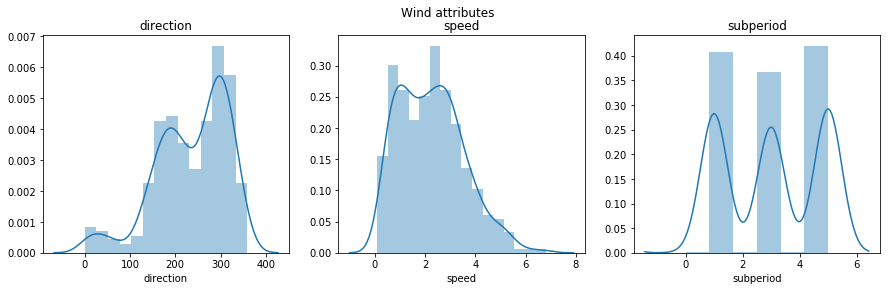

In [3]:
to_plot = wind.columns
fig, axs = plt.subplots(ncols=len(to_plot), figsize=(15, 4))
for ax, col in zip(axs, to_plot):
    sns.distplot(wind[col], ax=ax)
    ax.set_title(col)
plt.suptitle('Wind attributes')
plt.show()

## Question 1
Characterize the sensors’ performance and operation.  Are they all working properly at all times?  Can you detect any unexpected behaviors of the sensors through analyzing the readings they capture? Limit your response to no more than 9 images and 1000 words.

/home/dan/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:1325: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


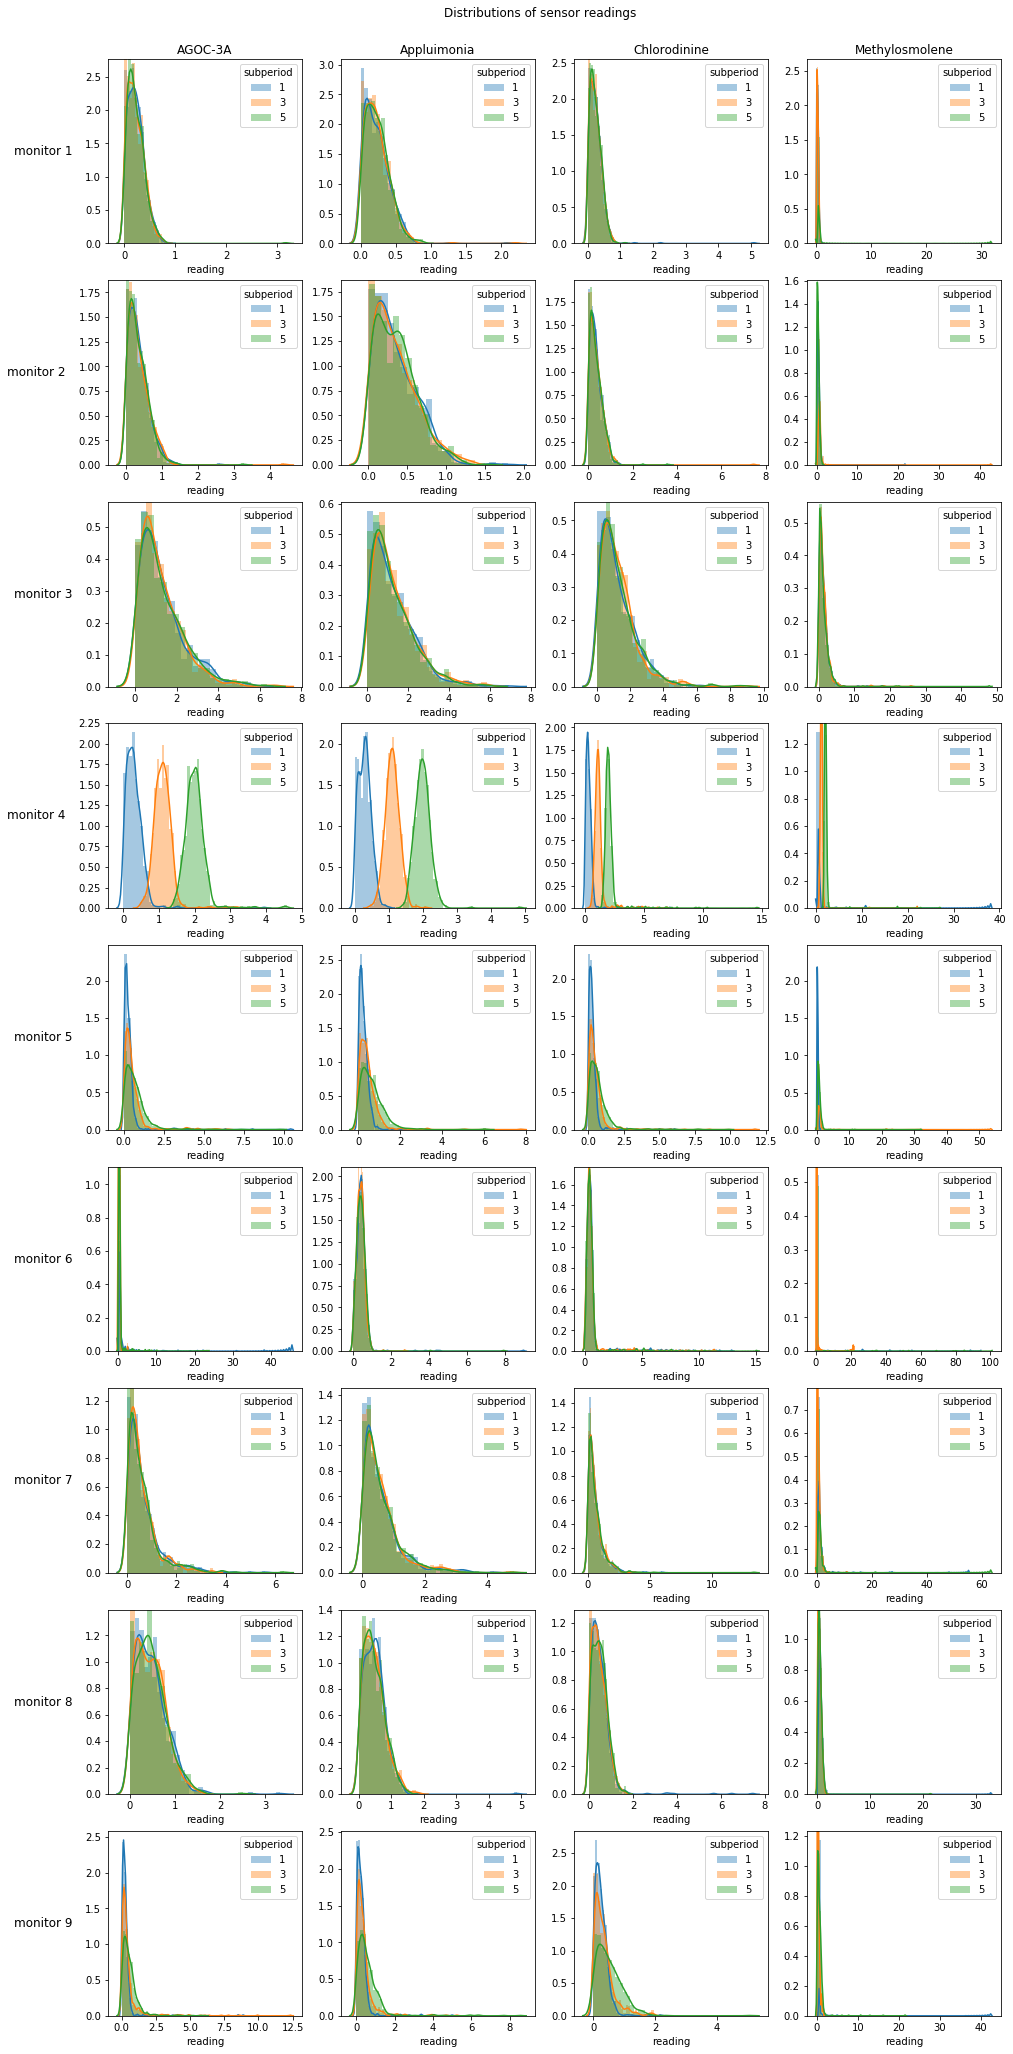

In [4]:
to_plot = all_joined[all_joined['has_wind_data']].reset_index().set_index(['subperiod'] + list(all_joined.index.names))
monitors = to_plot.index.get_level_values('monitor').unique().sort_values()
chemicals = to_plot.index.get_level_values('chemical').unique().sort_values()
periods = to_plot.index.get_level_values('subperiod').unique().sort_values()
fig, axs = plt.subplots(nrows=len(monitors), ncols=len(chemicals), figsize=(4*len(chemicals), 4*len(monitors)))
pad = 5
for ax, chemical in zip(axs[0], chemicals):
    ax.annotate(chemical, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')
for ax, monitor in zip(axs[:,0], monitors):
    ax.annotate('monitor {}'.format(monitor), xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
def transformed_readings(readings):
    #return np.clip(readings, 0, readings.quantile(0.99))
    return readings
for ax_row, monitor in zip(axs, monitors):
    for ax, chemical in zip(ax_row, chemicals):
        for period in periods:
            sns.distplot(transformed_readings(to_plot.loc[(period, chemical, monitor),'reading']), ax=ax, label=str(period))
        ax.legend(title='subperiod', loc='upper right')
plt.suptitle('Distributions of sensor readings', position=(0.5, 1-(0.9/len(monitors))))
plt.show()

## Question 2
Now turn your attention to the chemicals themselves.  Which chemicals are being detected by the sensor group?  What patterns of chemical releases do you see, as being reported in the data?  Limit your response to no more than 6 images and 500 words.

## Question 3
Which factories are responsible for which chemical releases? Carefully describe how you determined this using all the data you have available. For the factories you identified, describe any observed patterns of operation revealed in the data.  Limit your response to no more than 8 images and 1000 words.

#### TODO:
* radial plot centered on each sensor (direction = wind direction; distance = wind speed; darkness = concentration)

### Plume shape

In [5]:
# Adjusted sensor data
adj_sensor = sensor[sensor['unique']]['reading'].unstack('chemical').copy()
#adj_sensor /= adj_sensor.max()
chemical_info = pd.DataFrame({'color': ['red', 'blue', 'green', '#F39C12']}, index=adj_sensor.columns)
#chemical_info = pd.DataFrame({'color': ['red', 'blue', 'green', 'yellow']}, index=adj_sensor.columns)
#chemical_info = pd.DataFrame({'color': ['#C0392B', '#2980B9', '#9BBB59', '#F39C12']}, index=adj_sensor.columns)
adj_sensor = adj_sensor.unstack('monitor')
adj_sensor.columns = adj_sensor.columns.reorder_levels([1,0])
adj_sensor.sort_index(axis='columns', inplace=True)
adj_sensor.sort_index(axis='index', inplace=True)
adj_sensor.head(2)

monitor                     1                                          \
chemical              AGOC-3A Appluimonia Chlorodinine Methylosmolene   
timestamp                                                               
2016-04-01 00:00:00  0.160462    0.003093     0.382308       0.417423   
2016-04-01 01:00:00  0.065606    0.009519     0.325122       0.381961   

monitor                     2                                          \
chemical              AGOC-3A Appluimonia Chlorodinine Methylosmolene   
timestamp                                                               
2016-04-01 00:00:00  0.228558    0.518521     0.011573       0.110788   
2016-04-01 01:00:00  0.452257    0.152105     0.077714       0.225031   

monitor                     3                  ...                  7  \
chemical              AGOC-3A Appluimonia      ...       Chlorodinine   
timestamp                                      ...                      
2016-04-01 00:00:00  0.722303    0.130435      ...           0.943983   
2016-04-01 01:00:00  2.557360    3.484070      ...           1.267480   

monitor                                    8                           \
chemical            Methylosmolene   AGOC-3A Appluimonia Chlorodinine   
timestamp                                                               
2016-04-01 00:00:00        2.63064  0.438723    0.502186     0.225446   
2016-04-01 01:00:00        2.26404  0.535000    0.565845     0.708372   

monitor                                    9                           \
chemical            Methylosmolene   AGOC-3A Appluimonia Chlorodinine   
timestamp                                                               
2016-04-01 00:00:00       0.456104  0.105787    0.272886     0.197804   
2016-04-01 01:00:00       0.272105  0.123042    0.131138     0.345217   

monitor                             
chemical            Methylosmolene  
timestamp                           
2016-04-01 00:00:00       0.144993  
2016-04-01 01:00:00       0.186488  

[2 rows x 36 columns]

In [6]:
hover = bm.HoverTool(tooltips=[("type", "@type"), ("name", "@name"),])
factory_locations = locations[locations['type'] == 'factory'].copy()
factory_locations['x_offset'] = [-30,0,30,0]
sensor_locations = locations[locations['type'] == 'sensor'].copy()
sensor_locations.index = sensor_locations.index.astype(int)
annulus_radius_columns = ['radius_{}'.format(ndx) for ndx in range(len(chemical_info)+1)]
chemical_info['inner_radius_name'] = annulus_radius_columns[:-1]
chemical_info['outer_radius_name'] = annulus_radius_columns[1:]
for radius_col in annulus_radius_columns:
    sensor_locations[radius_col] = 0.0
factory_cds = bp.ColumnDataSource(factory_locations.reset_index())
sensor_cds = bp.ColumnDataSource(sensor_locations.reset_index())
sensor_nucleus_size = 2
plume_figure = bp.figure(title="Plume shape (use slider to select timestep)", plot_height=540, plot_width=900, x_range=(5, 15), y_range=(-1, 6), tools=[hover])
sensor_labels = bm.LabelSet(x='east_km', y='north_km', text='name', level='glyph', x_offset=5, y_offset=-30, source=sensor_cds)
plume_figure.add_layout(sensor_labels)
factory_labels = bm.LabelSet(x='east_km', y='north_km', text='name', level='glyph', text_align='center', x_offset='x_offset', y_offset=-20, source=factory_cds)
plume_figure.add_layout(factory_labels)
readings = {chem['chemical']: plume_figure.annulus(x='east_km', y='north_km', inner_radius=chem['inner_radius_name'], outer_radius=chem['outer_radius_name'], source=sensor_cds, color=chem['color'], legend=chem['chemical']) for chem in rows_as_series(chemical_info.reset_index())}
sensor_points = plume_figure.circle('east_km', 'north_km', source=sensor_cds, size=sensor_nucleus_size, color="black", alpha=1)
plumes = [plume_figure.line([factory['east_km']], [factory['north_km']], color="grey", line_width=3) for factory in rows_as_series(factory_locations)]
factory_points = plume_figure.circle('east_km', 'north_km', source=factory_cds, size=10, color="navy", alpha=1, legend='factory')
def difference(rng):
    return rng.end - rng.start
max_dists = np.array(list(map(difference, [plume_figure.x_range, plume_figure.y_range])))
coord_cols = ['east_km', 'north_km']
factory_coords = factory_locations[coord_cols].values[...,np.newaxis]
rows_per_segment = 10
filtered_final_plume_shapes = final_plume_shapes.iloc[(np.arange(len(final_plume_shapes))%rows_per_segment == 0) | final_plume_shapes.index.isin(adj_sensor.index),].copy()
adj_sensor = adj_sensor[adj_sensor.index.isin(filtered_final_plume_shapes.index)]
filtered_final_plume_shapes['ndx'] = range(len(filtered_final_plume_shapes))
subperiod_start_ordinates = filtered_final_plume_shapes.groupby('subperiod')['ndx'].first()
bio.show(plume_figure, notebook_handle=True)
base_area = np.pi * sensor_nucleus_size * sensor_nucleus_size*0
area_scale = 1 / adj_sensor.max().max()

@iw.interact(snapshot=iw.IntSlider(value=2, min=0, max=len(adj_sensor)-1, step=1, layout=iw.Layout(width='100%')))
def update_plumes(sens_1=True, sens_2=True, sens_3=True, sens_4=True, sens_5=True, sens_6=True, sens_7=True, sens_8=True, sens_9=True, AGOC=True, Appluimonia=True, Chlorodinine=True, Methylosmolene=True, save_frames=False, snapshot=0):
    _locals = locals()
    sensor_flags = np.array([_locals['sens_{}'.format(ndx)] for ndx in range(1, 10)])[...,np.newaxis].astype(int)
    chemical_flags = np.array([_locals[{'AGOC-3A':'AGOC'}.get(c,c)]  for c in chemical_info.index])[np.newaxis, ...].astype(int)
    timestamp = adj_sensor.index.values[snapshot]
    segment_ndx = filtered_final_plume_shapes['ndx'].loc[timestamp]
    reading_set = adj_sensor.iloc[snapshot:snapshot+1,].stack('monitor').reset_index('timestamp', drop=True).loc[sensor_locations.index.values, chemical_info.index.values]
    reading_radii = np.sqrt((base_area + (area_scale * sensor_flags * chemical_flags * reading_set.values).cumsum(axis=1))  / np.pi)
    sensor_cds.data.update(dict(zip(chemical_info['outer_radius_name'], reading_radii.T)))
    subperiod = filtered_final_plume_shapes['subperiod'].iloc[segment_ndx]
    displacements = filtered_final_plume_shapes[coord_cols].iloc[subperiod_start_ordinates.loc[subperiod]:segment_ndx]
    if len(displacements) == 0:
        plume_coords = np.array([0,0]).reshape((1,2,1)) + factory_coords
    else:
        plume_shape = displacements.values
        plume_shape -= plume_shape[-1:,:].copy()
        plume_shape = plume_shape[max([0, np.min(np.argwhere(np.any(np.abs(plume_shape) <= max_dists.reshape((1,-1)), axis=1)))-1]):,]
        plume_shape = plume_shape[-100:,]
        plume_coords = plume_shape.T[np.newaxis, ...] + factory_coords
    plume_figure.title.text = 'Plume shape at {timestamp} (subperiod {subperiod})'.format(**locals())
    for plume, coords in zip(plumes, plume_coords):
        plume.data_source.data.update(dict(zip(['x', 'y'], coords)))
    if save_frames:
        bio.export_png(plume_figure, out_path/('frames/mixed/frame_{snapshot}.png'.format(**locals())))
    bio.push_notebook()


In [7]:
def play_animation(sens_1=True, sens_2=True, sens_3=True, sens_4=True, sens_5=True, sens_6=True, sens_7=True, sens_8=True, sens_9=True, AGOC=True, Appluimonia=True, Chlorodinine=True, Methylosmolene=True, save_frames=False, start_snapshot=0, stop_snapshot=len(adj_sensor)):
    kwargs = locals()
    del kwargs['start_snapshot']
    del kwargs['stop_snapshot']
    for snapshot in range(start_snapshot, stop_snapshot):
        update_plumes(snapshot=snapshot, **kwargs)
    print('done')

#play_animation(save_frames=True)  # WARNING: this takes a long time
play_animation(save_frames=True, start_snapshot=1882)  # WARNING: this takes a long time

done
